## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random, os
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import image_dataset_from_directory

## Load dataset

In [6]:
IMG_SIZE = (224, 224)

### Train set

In [7]:
train_set = image_dataset_from_directory(
    directory = '../../../Datasets/Plant disease detection dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
    shuffle = True,
    batch_size = 32,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

Found 70295 files belonging to 38 classes.


In [8]:
test_set = image_dataset_from_directory(
    directory = '../../../Datasets/Plant disease detection dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    shuffle = True,
    batch_size = 32,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

Found 17572 files belonging to 38 classes.


In [9]:
labels = train_set.class_names
print(labels)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

## Observe random images

In [36]:
def view_rand_img(path = 'train'):
    dir_path = r'D:\Programming\Machine Learning\Datasets\Plant disease detection dataset\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)'
    dir_path = os.path.join(dir_path, path)
    rand_class = random.choice(os.listdir(dir_path))
    class_path = os.path.join(dir_path, rand_class)
    rand_img = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, rand_img)
    img = mpimg.imread(img_path)

    plt.style.use('dark_background')
    plt.figure(figsize = (3, 3))
    plt.imshow(img)
    plt.title(rand_class, fontsize = 10)
    plt.axis(False)
    


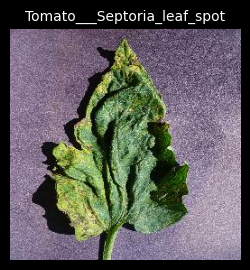

In [40]:
view_rand_img('valid')

## Setting up callbacks

In [47]:
model_chckpnt = ModelCheckpoint(
    'saved_model.ckpt',
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_accuracy',
    verbose = 1
)

def creat_tensorboard(experiment_name, logdir = 'TensorBoard_results'):
    return TensorBoard(log_dir = os.path.join(logdir, experiment_name))


## `EfficientNetB1 model`

In [41]:
from tensorflow.keras.applications import EfficientNetB1

In [58]:
effnetb1 = EfficientNetB1(include_top = False)
effnetb1.trainable = False

In [62]:
input_layer = Input(shape = (IMG_SIZE) + (3, ), name = 'input_layer')
base_model = effnetb1(input_layer, training = False)
x = GlobalAveragePooling2D(name = 'global_avg_pool')(base_model)
output_layer = Dense(units = len(labels), activation = 'softmax', name = 'output_layer')(x)

model = Model(inputs = input_layer, outputs = output_layer)

In [63]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(0.002),
              metrics = ['accuracy'])

In [64]:
history1 = model.fit(train_set, validation_data = test_set, epochs = 1)

2197/2197 [==============================] - 2719s 1s/step - loss: 0.2555 - accuracy: 0.9373 - val_loss: 0.1131 - val_accuracy: 0.9660


In [65]:
test_loss, test_acc = model.evaluate(test_set, verbose = 1)

print(f"Test loss after just one epoch : {test_loss:.3f}")
print(f"Test accuracy after just one epoch : {test_acc:.3f}")

550/550 [==============================] - 555s 1s/step - loss: 0.1131 - accuracy: 0.9660
Test loss after just one epoch : 0.113
Test accuracy after just one epoch : 0.966


In [ ]:
model.save('model_1.h5')

## Load and evaluate the model

In [2]:
from tensorflow.keras.models import load_model

In [3]:
my_model = load_model('./model_1.h5')

In [11]:
def pred_rand_img(model = my_model, classes = labels):
    path = 'valid'
    dir_path = r'D:\Programming\Machine Learning\Datasets\Plant disease detection dataset\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)'
    dir_path = os.path.join(dir_path, path)
    rand_class = random.choice(os.listdir(dir_path))
    class_path = os.path.join(dir_path, rand_class)
    rand_img = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, rand_img)
    img = load_img(img_path, target_size = (224, 224, 3))
    # img = img_to_array(img)/255.    # No need for rescaling, as EfficientNet has already built in Rescaling layer, if we rescale again, it will produce wrong results
    img = np.expand_dims(img, axis = 0)
    pred_img = np.argmax(model.predict(img), axis = 1)
    pred_class = classes[pred_img[0]]
    
    plt.style.use('dark_background')
    plt.figure(figsize = (3, 3))
    plt.imshow(np.squeeze(img))
    plt.xlabel(f"Actual:{rand_class}", fontsize = 10, fontweight = 'bold')
    if(rand_class == pred_class):
        plt.title(f"Actual: {rand_class}\nPredicted: {pred_class}", color = 'green', fontsize = 10, fontweight = 'bold')
    else:
        plt.title(f"Actual: {rand_class}\nPredicted: {pred_class}", color = 'red', fontsize = 10, fontweight = 'bold')

    plt.axis(False)
    


1/1 [==============================] - 0s 97ms/step


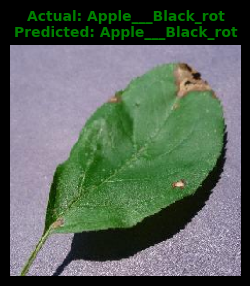

In [20]:
pred_rand_img()